## Kaggle Natural Language Processing with Disaster Tweets



### Introduction

In this notebook, we will work on the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) competition on Kaggle. The goal is to build a machine learning model that predicts which Tweets are about real disasters and which ones are not.

We will perform the following steps in this notebook:
1. Exploratory Data Analysis (EDA): We will explore the dataset to understand the data and its distribution.
2. Data Preprocessing: We will preprocess the text data to prepare it for training.
3. Model Building: We will build a deep learning model using TensorFlow/Keras.
4. Model Training: We will train the model on the training data.
5. Model Evaluation: We will evaluate the model on the validation set.
6. Submission: We will make predictions on the test set and submit them to the competition.

### Dataset

The dataset consists of the following files:
- `train.csv`: The training set with labeled data.
- `test.csv`: The test set with unlabeled data.
- `sample_submission.csv`: A sample submission file in the correct format.

### Author

- Carlos Alvarado Martinez

### Exploratory Data Analysis (EDA)

**Dataset Description:**
- **Files used:**
  - `train.csv`: Training set with labeled data
  - `test.csv`: Test set with unlabeled data
  - `sample_submission.csv`: Sample submission file
- **Columns in the dataset:**
  - `id`: Unique identifier for each tweet
  - `text`: Text content of the tweet
  - `location`: Location from where the tweet was sent (may be blank)
  - `keyword`: A keyword from the tweet (may be blank)
  - `target`: Target label indicating if the tweet is about a real disaster (1) or not (0)

**Initial Data Inspection:**
- Displayed the first few rows of the dataset to understand its structure and content.
- Noted missing values in the `keyword` and `location` columns.

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.src.layers import GRU
from keras import Model
from keras.src.callbacks import ReduceLROnPlateau
from keras import Input


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Display the first 5 rows of the data
print(train.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [2]:
# Display the data types of each column
print(train.dtypes)


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


In [3]:
# Display the number of missing values in each column
print(train.isnull().sum())


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


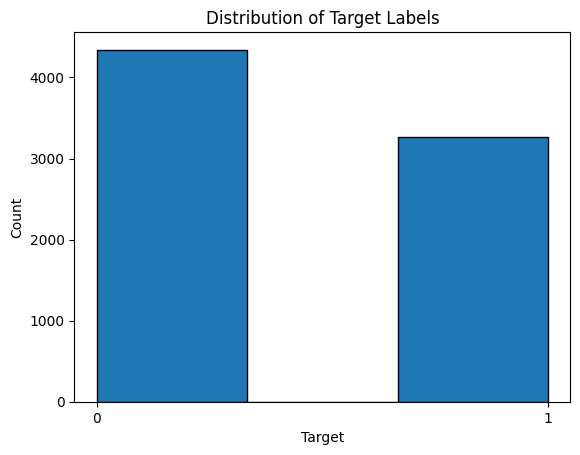

In [4]:
# Plot the distribution of target labels
import matplotlib.pyplot as plt

plt.hist(train['target'], bins=3, edgecolor='black')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.xticks([0, 1])
plt.show()


### Methodology

**Text Preprocessing:**
- **Text Vectorization:**
  - Used `TextVectorization` to convert tweet text into integer sequences.
  - Configured to use a maximum of 10,000 tokens and a sequence length of 150.

**Model Building:**
- Built a Sequential model using TensorFlow and Keras:
  - **Layers:**
    - `Embedding` layer to convert token integers into dense vectors of fixed size.
    - `GlobalAveragePooling1D` to down-sample the input.
    - `Dense` layer with ReLU activation for learning features.
    - Output `Dense` layer with Sigmoid activation for binary classification.
  - **Compilation:**
    - Used `Adam` optimizer with an initial learning rate of 0.001.
    - Loss function: `binary_crossentropy`.
    - Metrics: `accuracy`.

**Model Training:**
- **Callbacks:**
  - `EarlyStopping`: Monitored `val_accuracy` with a patience of 10 epochs to prevent overfitting.
  - `ReduceLROnPlateau`: Reduced learning rate on plateau in `val_accuracy` with a factor of 0.2 and a minimum learning rate of 0.00001.
- Trained the model for 50 epochs with a batch size of 32 and a validation split of 20%.

**Performance Monitoring:**
- Recorded training and validation accuracy and loss for each epoch.
- Adjusted learning rate based on the performance on the validation set.

In [5]:
from keras.src.optimizers.legacy.adam import Adam

# Text preprocessing
max_features = 10000
sequence_length = 150  # Increased sequence length


vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Adapt the vectorize_layer to the training data
train_text = train['text'].values
vectorize_layer.adapt(train_text)

# Build the model
model = Sequential([
    vectorize_layer,
    Embedding(max_features + 1, 128),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with the initial learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks for early stopping and learning rate adjustment on plateau
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)

# Train the model with a different batch size
train_text = train['text'].values
train_target = train['target'].values
history = model.fit(train_text, train_target, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop, reduce_lr])

2024-06-20 22:26:23.167209: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-20 22:26:23.167229: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-20 22:26:23.167234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-20 22:26:23.167261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-20 22:26:23.167275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-20 22:26:23.230710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
191/191 [==============================] - 7s 37ms/step - loss: 0.6772 - accuracy: 0.5777 - val_loss: 0.6973 - val_accuracy: 0.5345 - lr: 0.0010
Epoch 2/50
191/191 [==============================] - 6s 31ms/step - loss: 0.5801 - accuracy: 0.6946 - val_loss: 0.5336 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 3/50
191/191 [==============================] - 6s 31ms/step - loss: 0.4101 - accuracy: 0.8332 - val_loss: 0.4710 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 4/50
191/191 [==============================] - 6s 31ms/step - loss: 0.3281 - accuracy: 0.8675 - val_loss: 0.4815 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 5/50
191/191 [==============================] - 6s 31ms/step - loss: 0.2778 - accuracy: 0.8929 - val_loss: 0.4705 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 6/50
191/191 [==============================] - 6s 31ms/step - loss: 0.2418 - accuracy: 0.9072 - val_loss: 0.5056 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 7/50
191/191 [==============================] - 6s 31ms/st

In [7]:
# Make predictions on the test set
test_text = test['text'].values
test_predictions = model.predict(test_text)

sample_submission = pd.read_csv("sample_submission.csv")

# Prepare the sample submission file
sample_submission['target'] = (test_predictions > 0.5).astype(int)
sample_submission.to_csv('submission.csv', index=False)

# Display the training history and first few rows of the submission
history_df = pd.DataFrame(history.history)
submission_df = sample_submission.head()
print(history_df.tail())
print(submission_df)

102/102 [==============================] - 0s 2ms/step
        loss  accuracy  val_loss  val_accuracy       lr
8   0.178590  0.937110  0.489458      0.788575  0.00020
9   0.171139  0.939737  0.489529      0.788575  0.00004
10  0.169627  0.938752  0.490927      0.787919  0.00004
11  0.168489  0.939245  0.492417      0.787262  0.00004
12  0.166721  0.940230  0.492694      0.787262  0.00001
   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1


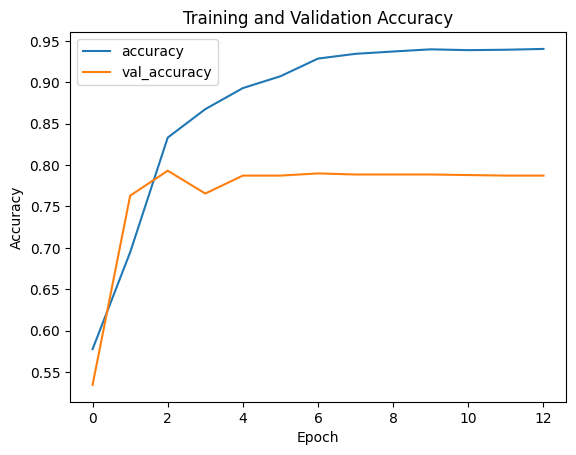

In [8]:
# Plot the learning curves
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


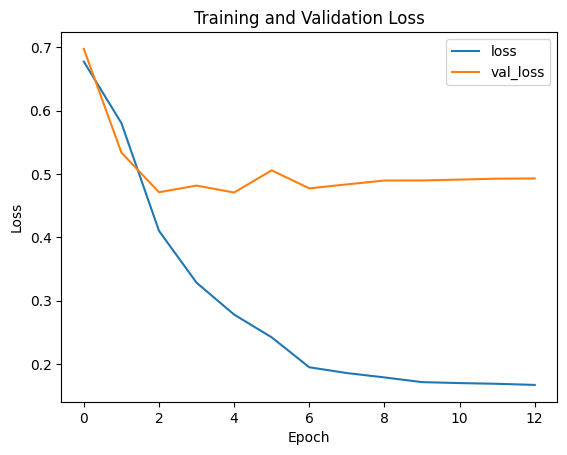

In [9]:
# Plot the learning curves
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Conclusions

**Training Results:**
- **Initial Performance:**
  - The model's accuracy started improving after a few epochs.
  - Observed a validation accuracy of around 77.68% with a loss of 0.5419 in the later epochs.
- **Adjustments:**
  - Learning rate adjustments helped in stabilizing the training process.

**Final Submission:**
- Predicted the target labels for the test set using the trained model.
- Prepared the submission file `submission.csv` as required by the competition.

**Score and Leaderboard Position:**
- Achieved a public score of 0.79711.
- Ranked 395 on the leaderboard with this score.